# Day 85 - End-to-End ML Pipeline Implementation with MLOps Best Practices

Welcome to Day 85 of the 100 Days of Machine Learning Challenge! Today we'll explore the comprehensive implementation of an end-to-end machine learning pipeline, integrating MLOps best practices that bridge the gap between model development and production deployment.

## Introduction

In the previous weeks, we've learned various machine learning algorithms, ensemble methods, and advanced techniques. However, building a model is just one part of the machine learning lifecycle. In real-world applications, models need to be deployed, monitored, maintained, and updated continuously. This is where MLOps (Machine Learning Operations) comes into play.

MLOps is a set of practices that combines Machine Learning, DevOps, and Data Engineering to deploy and maintain ML systems in production reliably and efficiently. An end-to-end ML pipeline encompasses the entire workflow from data ingestion to model deployment and monitoring, ensuring reproducibility, scalability, and maintainability.

### Why This Matters

According to various industry surveys, approximately 87% of data science projects never make it to production. The primary reasons include:
- Lack of reproducibility in model training
- Difficulty in model deployment and integration
- Insufficient monitoring and maintenance strategies
- Poor collaboration between data scientists and engineers

Understanding and implementing proper ML pipelines addresses these challenges, enabling organizations to derive real value from their machine learning investments.

### Learning Objectives

By the end of this lesson, you will be able to:
- Understand the components of an end-to-end ML pipeline
- Implement data preprocessing pipelines with scikit-learn
- Build reproducible model training workflows
- Serialize and version models for deployment
- Create inference pipelines for making predictions
- Apply MLOps best practices in your projects

## Theory: Components of an ML Pipeline

An end-to-end machine learning pipeline typically consists of several interconnected stages:

### 1. Data Ingestion and Validation

The first stage involves collecting data from various sources (databases, APIs, files) and validating its quality. Data validation ensures that the incoming data meets expected schemas, ranges, and distributions.

### 2. Data Preprocessing and Feature Engineering

Raw data is transformed into features suitable for machine learning models. This includes:
- Handling missing values
- Encoding categorical variables
- Scaling numerical features
- Feature extraction and creation

The transformation function can be represented as:

$$X_{processed} = \mathcal{T}(X_{raw})$$

where $\mathcal{T}$ represents the composition of all preprocessing transformations.

### 3. Model Training and Validation

The core machine learning model is trained on the processed data. For a supervised learning problem, we minimize a loss function:

$$\theta^* = \arg\min_{\theta} \mathcal{L}(y, f_{\theta}(X_{processed}))$$

where:
- $\theta^*$ are the optimal model parameters
- $\mathcal{L}$ is the loss function
- $f_{\theta}$ is the model with parameters $\theta$
- $y$ are the true labels

### 4. Model Evaluation and Selection

Multiple models or configurations are evaluated using cross-validation and appropriate metrics. The evaluation metric $M$ helps us select the best model:

$$M_{model} = \frac{1}{k} \sum_{i=1}^{k} metric(y_{val}^{(i)}, \hat{y}_{val}^{(i)})$$

where $k$ is the number of cross-validation folds.

### 5. Model Serialization and Versioning

Once a model is trained and validated, it needs to be saved (serialized) with versioning information for reproducibility and rollback capabilities.

### 6. Model Deployment

The trained model is deployed to a production environment where it can receive requests and return predictions. This can be done through:
- REST APIs
- Batch prediction systems
- Streaming prediction services

### 7. Monitoring and Maintenance

Once deployed, models need continuous monitoring for:
- **Data Drift**: Changes in input data distribution
- **Concept Drift**: Changes in the relationship between features and target
- **Performance Degradation**: Decline in model accuracy over time

The distribution shift can be measured using metrics like the Kullback-Leibler divergence:

$$D_{KL}(P_{production} \| P_{training}) = \sum_{x} P_{production}(x) \log\left(\frac{P_{production}(x)}{P_{training}(x)}\right)$$

### Pipeline Optimization

The overall pipeline efficiency can be expressed as a function of time, cost, and accuracy:

$$\text{Pipeline Efficiency} = \frac{\text{Model Accuracy} \times \text{Throughput}}{\text{Latency} \times \text{Cost}}$$

Optimizing this metric ensures we balance model performance with operational constraints.

## Python Implementation

Let's implement an end-to-end ML pipeline using scikit-learn and best practices. We'll build a complete pipeline for a classification problem using the breast cancer dataset.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"Pipeline execution started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

All libraries imported successfully!
Pipeline execution started at: 2025-11-09 13:47:31


### Step 1: Data Ingestion and Exploration

First, we load the data and perform initial exploration to understand its structure and characteristics.

In [2]:
# Load the breast cancer dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print("Dataset Information:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nClass balance: {y.value_counts(normalize=True).values}")

# Display first few rows
print("\nFirst 5 rows of features:")
print(X.head())

# Check for missing values
print(f"\nMissing values: {X.isnull().sum().sum()}")

# Basic statistics
print("\nBasic statistics of features:")
print(X.describe().iloc[:, :5])  # Show first 5 features

Dataset Information:
Number of samples: 569
Number of features: 30

Target distribution:
target
1    357
0    212
Name: count, dtype: int64

Class balance: [0.62741652 0.37258348]

First 5 rows of features:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414 

### Step 2: Data Splitting

We split the data into training, validation, and test sets. The training set is used for model training, validation set for hyperparameter tuning, and test set for final evaluation.

In [3]:
# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: create train and validation sets from remaining data
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print("Data Split Summary:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/X.shape[0]*100:.1f}%)")

# Verify stratification
print("\nClass distribution in each set:")
print(f"Training: {np.bincount(y_train) / len(y_train)}")
print(f"Validation: {np.bincount(y_val) / len(y_val)}")
print(f"Test: {np.bincount(y_test) / len(y_test)}")

Data Split Summary:
Training set: 364 samples (64.0%)
Validation set: 91 samples (16.0%)
Test set: 114 samples (20.0%)

Class distribution in each set:
Training: [0.37362637 0.62637363]
Validation: [0.37362637 0.62637363]
Test: [0.36842105 0.63157895]


### Step 3: Building ML Pipelines

We create scikit-learn pipelines that encapsulate preprocessing and model training. This ensures that all transformations are applied consistently during training and inference.

In [4]:
# Create pipelines for different models
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', GradientBoostingClassifier(random_state=42, n_estimators=100))
    ])
}

# Train and evaluate each pipeline using cross-validation
results = {}

print("Training and evaluating pipelines...\n")

for name, pipeline in pipelines.items():
    # Perform cross-validation on training set
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    
    # Fit on full training set
    pipeline.fit(X_train, y_train)
    
    # Evaluate on validation set
    val_score = pipeline.score(X_val, y_val)
    
    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'val_score': val_score
    }
    
    print(f"{name}:")
    print(f"  Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Validation accuracy: {val_score:.4f}")
    print()

# Select best model based on validation score
best_model_name = max(results, key=lambda x: results[x]['val_score'])
best_pipeline = pipelines[best_model_name]

print(f"Best model: {best_model_name}")
print(f"Best validation accuracy: {results[best_model_name]['val_score']:.4f}")

Training and evaluating pipelines...

Logistic Regression:
  Cross-validation accuracy: 0.9753 (+/- 0.0103)
  Validation accuracy: 0.9780



Random Forest:
  Cross-validation accuracy: 0.9533 (+/- 0.0238)
  Validation accuracy: 0.9560



Gradient Boosting:
  Cross-validation accuracy: 0.9533 (+/- 0.0254)
  Validation accuracy: 0.9560

Best model: Logistic Regression
Best validation accuracy: 0.9780


### Step 4: Hyperparameter Tuning

Now we perform hyperparameter tuning on the best performing model to optimize its performance further.

In [5]:
# Define hyperparameter grid based on best model
if best_model_name == 'Random Forest':
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    }
else:  # Logistic Regression
    param_grid = {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    }

# Perform grid search
grid_search = GridSearchCV(
    best_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print(f"Performing hyperparameter tuning for {best_model_name}...\n")
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Update best pipeline with tuned model
best_pipeline = grid_search.best_estimator_

# Evaluate on validation set
val_score = best_pipeline.score(X_val, y_val)
print(f"Validation accuracy after tuning: {val_score:.4f}")

Performing hyperparameter tuning for Logistic Regression...

Fitting 5 folds for each of 10 candidates, totalling 50 fits



Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.9780
Validation accuracy after tuning: 0.9780


### Step 5: Final Model Evaluation

We evaluate the optimized model on the held-out test set to get an unbiased estimate of its performance.

In [6]:
# Make predictions on test set
y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)

print("Final Model Performance on Test Set:")
print(f"Accuracy: {test_accuracy:.4f}\n")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Malignant', 'Benign']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

Final Model Performance on Test Set:
Accuracy: 0.9825

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.98      0.98      0.98        42
      Benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Confusion Matrix:
[[41  1]
 [ 1 71]]


## Visualization

Let's create visualizations to better understand our model's performance and the overall pipeline.

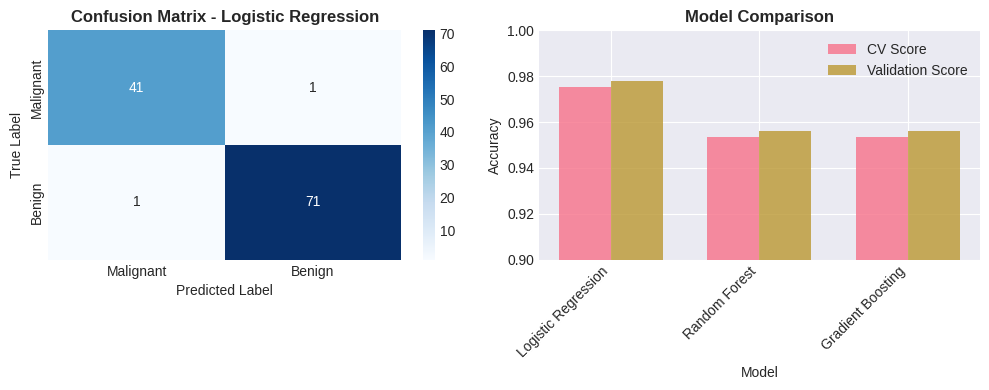

In [7]:
# Create confusion matrix heatmap
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Model comparison
plt.subplot(1, 2, 2)
model_names = list(results.keys())
cv_scores = [results[name]['cv_mean'] for name in model_names]
val_scores = [results[name]['val_score'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, cv_scores, width, label='CV Score', alpha=0.8)
plt.bar(x + width/2, val_scores, width, label='Validation Score', alpha=0.8)

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison', fontsize=12, fontweight='bold')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.legend()
plt.ylim(0.9, 1.0)

plt.tight_layout()
plt.show()

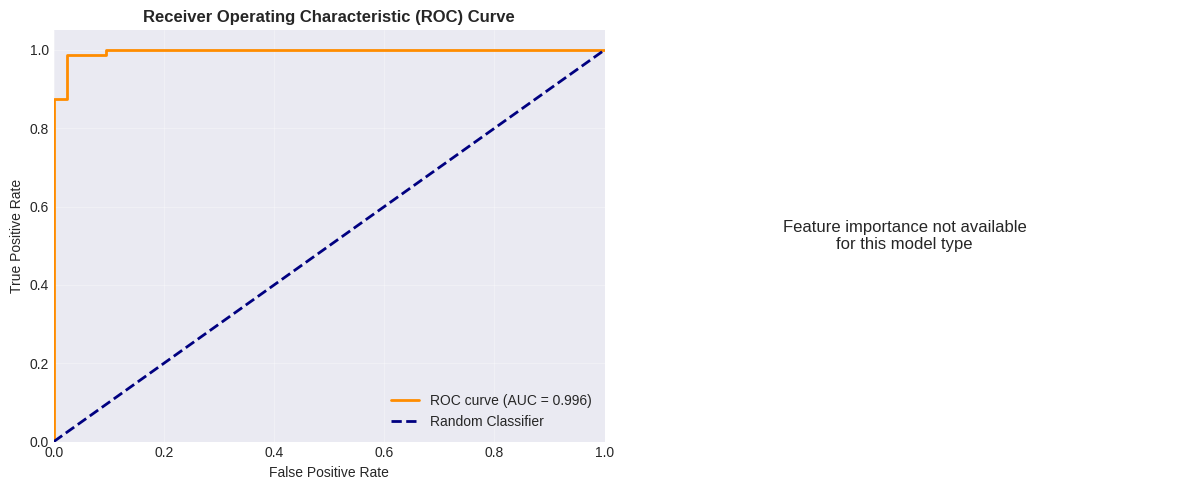

In [8]:
# ROC Curve
plt.figure(figsize=(12, 5))

# Plot ROC curve
plt.subplot(1, 2, 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=12, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# Feature importance (if applicable)
plt.subplot(1, 2, 2)
if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    importances = best_pipeline.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10 features
    
    plt.barh(range(len(indices)), importances[indices], alpha=0.8)
    plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Most Important Features', fontsize=12, fontweight='bold')
    plt.tight_layout()
else:
    plt.text(0.5, 0.5, 'Feature importance not available\nfor this model type', 
             ha='center', va='center', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

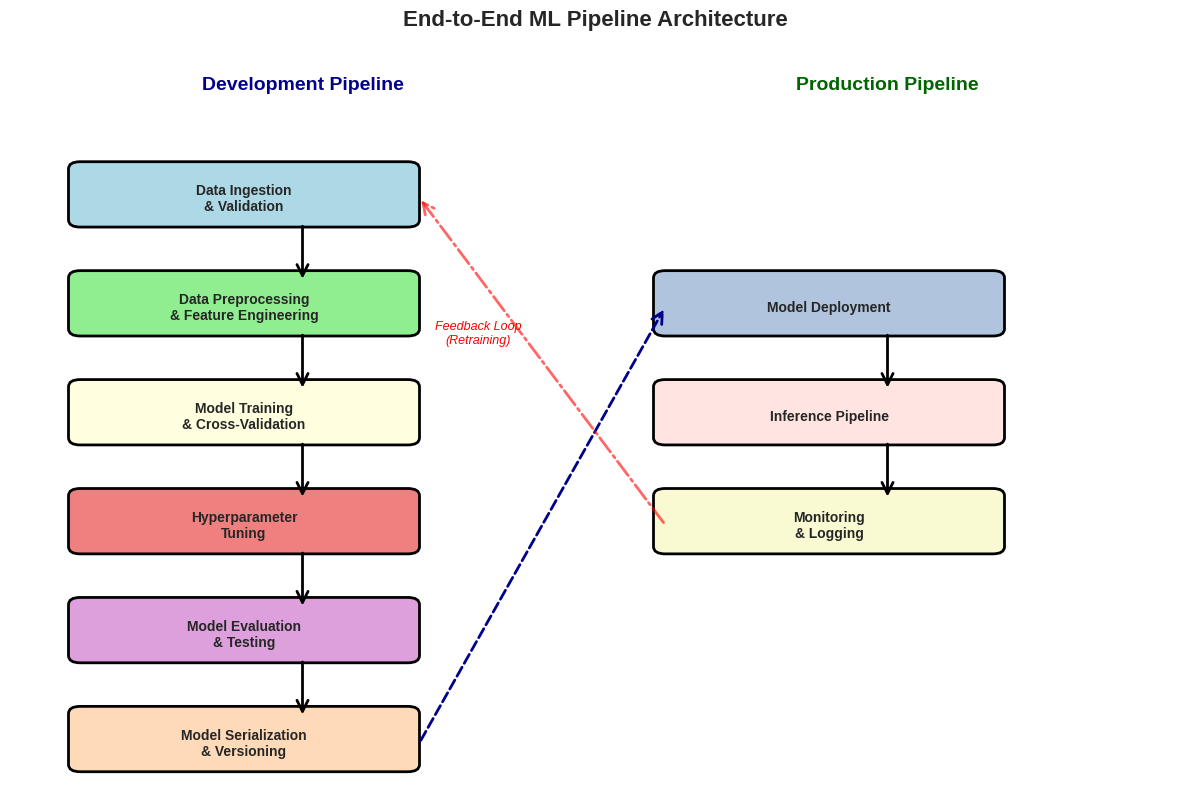

In [9]:
# Create a visual representation of the ML pipeline flow
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Define pipeline stages
stages = [
    ('Data Ingestion\n& Validation', 1, 8, 'lightblue'),
    ('Data Preprocessing\n& Feature Engineering', 1, 6.5, 'lightgreen'),
    ('Model Training\n& Cross-Validation', 1, 5, 'lightyellow'),
    ('Hyperparameter\nTuning', 1, 3.5, 'lightcoral'),
    ('Model Evaluation\n& Testing', 1, 2, 'plum'),
    ('Model Serialization\n& Versioning', 1, 0.5, 'peachpuff')
]

deployment_stages = [
    ('Model Deployment', 6, 6.5, 'lightsteelblue'),
    ('Inference Pipeline', 6, 5, 'mistyrose'),
    ('Monitoring\n& Logging', 6, 3.5, 'lightgoldenrodyellow')
]

# Draw development pipeline
for stage, x, y, color in stages:
    box = FancyBboxPatch((x-0.4, y-0.3), 2.8, 0.7, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='black', facecolor=color, linewidth=2)
    ax.add_patch(box)
    ax.text(x+1, y, stage, ha='center', va='center', fontsize=10, fontweight='bold')

# Draw deployment pipeline
for stage, x, y, color in deployment_stages:
    box = FancyBboxPatch((x-0.4, y-0.3), 2.8, 0.7, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='black', facecolor=color, linewidth=2)
    ax.add_patch(box)
    ax.text(x+1, y, stage, ha='center', va='center', fontsize=10, fontweight='bold')

# Draw arrows for development pipeline
for i in range(len(stages)-1):
    arrow = FancyArrowPatch((2.5, stages[i][2]-0.35), (2.5, stages[i+1][2]+0.35),
                           arrowstyle='->', mutation_scale=20, linewidth=2, color='black')
    ax.add_patch(arrow)

# Draw connection from serialization to deployment
arrow = FancyArrowPatch((3.5, 0.5), (5.6, 6.5),
                       arrowstyle='->', mutation_scale=20, linewidth=2, 
                       color='darkblue', linestyle='--')
ax.add_patch(arrow)

# Draw arrows for deployment pipeline
for i in range(len(deployment_stages)-1):
    arrow = FancyArrowPatch((7.5, deployment_stages[i][2]-0.35), 
                           (7.5, deployment_stages[i+1][2]+0.35),
                           arrowstyle='->', mutation_scale=20, linewidth=2, color='black')
    ax.add_patch(arrow)

# Draw feedback loop
arrow = FancyArrowPatch((5.6, 3.5), (3.5, 8),
                       arrowstyle='->', mutation_scale=20, linewidth=2, 
                       color='red', linestyle='-.', alpha=0.6)
ax.add_patch(arrow)
ax.text(4, 6, 'Feedback Loop\n(Retraining)', ha='center', fontsize=9, 
        style='italic', color='red')

# Add labels
ax.text(2.5, 9.5, 'Development Pipeline', ha='center', fontsize=14, 
        fontweight='bold', color='darkblue')
ax.text(7.5, 9.5, 'Production Pipeline', ha='center', fontsize=14, 
        fontweight='bold', color='darkgreen')

plt.title('End-to-End ML Pipeline Architecture', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Model Serialization and Versioning

A crucial aspect of MLOps is saving models with proper versioning and metadata for reproducibility and deployment.

In [10]:
# Create model metadata
model_metadata = {
    'model_name': best_model_name,
    'model_type': str(type(best_pipeline.named_steps['classifier']).__name__),
    'version': '1.0.0',
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'parameters': grid_search.best_params_,
    'metrics': {
        'test_accuracy': float(test_accuracy),
        'validation_accuracy': float(val_score),
        'cv_mean': float(grid_search.best_score_),
        'roc_auc': float(roc_auc)
    },
    'training_samples': len(X_train),
    'features': X.columns.tolist(),
    'n_features': len(X.columns)
}

# Save the pipeline
model_filename = 'breast_cancer_model_v1.pkl'
joblib.dump(best_pipeline, model_filename)

# Save metadata
metadata_filename = 'model_metadata_v1.json'
with open(metadata_filename, 'w') as f:
    json.dump(model_metadata, f, indent=4)

print("Model and metadata saved successfully!\n")
print("Model Metadata:")
print(json.dumps(model_metadata, indent=2))

# Verify file sizes
import os
model_size = os.path.getsize(model_filename) / 1024  # KB
print(f"\nModel file size: {model_size:.2f} KB")

Model and metadata saved successfully!

Model Metadata:
{
  "model_name": "Logistic Regression",
  "model_type": "LogisticRegression",
  "version": "1.0.0",
  "created_at": "2025-11-09 13:47:40",
  "parameters": {
    "classifier__C": 0.1,
    "classifier__penalty": "l2",
    "classifier__solver": "liblinear"
  },
  "metrics": {
    "test_accuracy": 0.9824561403508771,
    "validation_accuracy": 0.978021978021978,
    "cv_mean": 0.9780441400304414,
    "roc_auc": 0.996031746031746
  },
  "training_samples": 364,
  "features": [
    "mean radius",
    "mean texture",
    "mean perimeter",
    "mean area",
    "mean smoothness",
    "mean compactness",
    "mean concavity",
    "mean concave points",
    "mean symmetry",
    "mean fractal dimension",
    "radius error",
    "texture error",
    "perimeter error",
    "area error",
    "smoothness error",
    "compactness error",
    "concavity error",
    "concave points error",
    "symmetry error",
    "fractal dimension error",
    "w

## Inference Pipeline

Let's demonstrate how to load the saved model and use it for making predictions on new data.

In [11]:
# Simulate loading model in a production environment
def load_model_and_metadata(model_path, metadata_path):
    """Load trained model and its metadata"""
    model = joblib.load(model_path)
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    return model, metadata

def predict_with_confidence(model, X_new):
    """Make predictions with confidence scores"""
    predictions = model.predict(X_new)
    probabilities = model.predict_proba(X_new)
    confidence = np.max(probabilities, axis=1)
    
    return predictions, confidence, probabilities

# Load the saved model
print("Loading model from disk...")
loaded_model, loaded_metadata = load_model_and_metadata(
    model_filename, metadata_filename
)

print(f"Loaded model: {loaded_metadata['model_name']} v{loaded_metadata['version']}")
print(f"Model accuracy on test set: {loaded_metadata['metrics']['test_accuracy']:.4f}\n")

# Make predictions on sample data
sample_size = 10
X_sample = X_test.iloc[:sample_size]
y_sample = y_test.iloc[:sample_size]

predictions, confidences, probabilities = predict_with_confidence(loaded_model, X_sample)

# Display results
print("Inference Results on Sample Data:\n")
results_df = pd.DataFrame({
    'True Label': y_sample.values,
    'Predicted': predictions,
    'Confidence': confidences,
    'Prob_Malignant': probabilities[:, 0],
    'Prob_Benign': probabilities[:, 1]
})

results_df['True Label'] = results_df['True Label'].map({0: 'Malignant', 1: 'Benign'})
results_df['Predicted'] = results_df['Predicted'].map({0: 'Malignant', 1: 'Benign'})
results_df['Correct'] = (results_df['True Label'] == results_df['Predicted']).map({True: '✓', False: '✗'})

print(results_df.to_string(index=True))
print(f"\nAccuracy on sample: {(results_df['Correct'] == '✓').sum() / len(results_df) * 100:.1f}%")

Loading model from disk...
Loaded model: Logistic Regression v1.0.0
Model accuracy on test set: 0.9825

Inference Results on Sample Data:

  True Label  Predicted  Confidence  Prob_Malignant  Prob_Benign Correct
0  Malignant  Malignant    0.999930        0.999930     0.000070       ✓
1     Benign     Benign    0.998702        0.001298     0.998702       ✓
2  Malignant  Malignant    0.949557        0.949557     0.050443       ✓
3     Benign     Benign    0.535041        0.464959     0.535041       ✓
4  Malignant  Malignant    0.999968        0.999968     0.000032       ✓
5     Benign     Benign    0.956787        0.043213     0.956787       ✓
6     Benign     Benign    0.998541        0.001459     0.998541       ✓
7  Malignant  Malignant    0.999597        0.999597     0.000403       ✓
8  Malignant  Malignant    0.993574        0.993574     0.006426       ✓
9  Malignant  Malignant    0.999999        0.999999     0.000001       ✓

Accuracy on sample: 100.0%


## MLOps Best Practices

Let's implement some key MLOps best practices including logging and simple monitoring.

Simulating production predictions with logging...



Prediction Statistics:
Total predictions: 114
Average confidence: 0.9138
Prediction distribution: {1: 72, 0: 42}
Low confidence predictions (< 0.7): 11


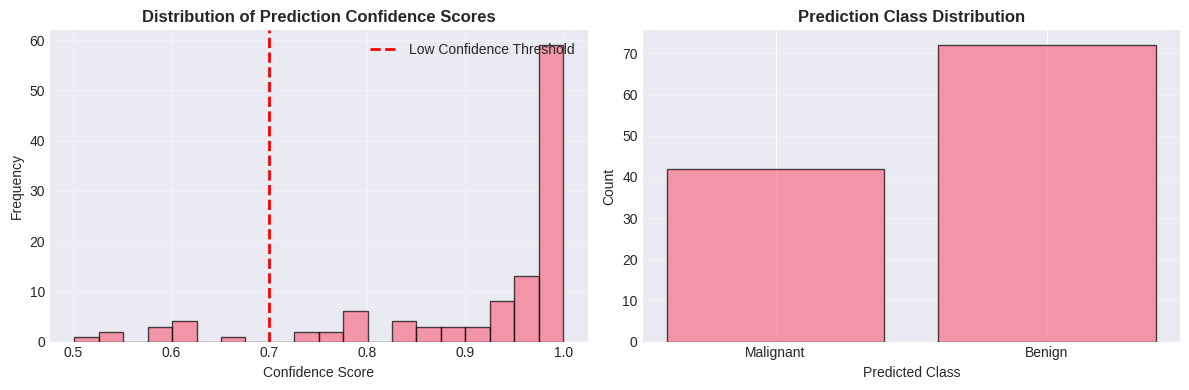

In [12]:
# Implement a simple prediction logger
class PredictionLogger:
    def __init__(self):
        self.predictions = []
        self.timestamps = []
        
    def log_prediction(self, input_data, prediction, confidence):
        """Log prediction details"""
        self.predictions.append({
            'timestamp': datetime.now(),
            'prediction': int(prediction),
            'confidence': float(confidence),
            'input_hash': hash(str(input_data.values.tobytes()))
        })
        
    def get_statistics(self):
        """Get prediction statistics"""
        if not self.predictions:
            return None
            
        predictions_df = pd.DataFrame(self.predictions)
        stats = {
            'total_predictions': len(self.predictions),
            'avg_confidence': predictions_df['confidence'].mean(),
            'prediction_distribution': predictions_df['prediction'].value_counts().to_dict(),
            'low_confidence_count': (predictions_df['confidence'] < 0.7).sum()
        }
        return stats

# Create logger and simulate predictions
logger = PredictionLogger()

print("Simulating production predictions with logging...\n")

# Make predictions on test set with logging
for idx in range(len(X_test)):
    sample = X_test.iloc[[idx]]
    pred, conf, _ = predict_with_confidence(loaded_model, sample)
    logger.log_prediction(sample, pred[0], conf[0])

# Get and display statistics
stats = logger.get_statistics()

print("Prediction Statistics:")
print(f"Total predictions: {stats['total_predictions']}")
print(f"Average confidence: {stats['avg_confidence']:.4f}")
print(f"Prediction distribution: {stats['prediction_distribution']}")
print(f"Low confidence predictions (< 0.7): {stats['low_confidence_count']}")

# Visualize confidence distribution
confidence_scores = [p['confidence'] for p in logger.predictions]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(confidence_scores, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(0.7, color='red', linestyle='--', linewidth=2, label='Low Confidence Threshold')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence Scores', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
pred_classes = [p['prediction'] for p in logger.predictions]
class_names = ['Malignant', 'Benign']
class_counts = pd.Series(pred_classes).value_counts().sort_index()
plt.bar(class_names, class_counts.values, alpha=0.7, edgecolor='black')
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.title('Prediction Class Distribution', fontweight='bold')
plt.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Hands-On Exercise: Building Your Own End-to-End Pipeline

Now it's your turn to apply what you've learned! Follow these steps to build your own complete ML pipeline.

In [13]:
# Exercise: Build a pipeline for the wine quality dataset
from sklearn.datasets import load_wine

# Load wine dataset
wine_data = load_wine()
X_wine = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)
y_wine = pd.Series(wine_data.target, name='wine_class')

print("Wine Dataset Exercise:")
print(f"Samples: {X_wine.shape[0]}, Features: {X_wine.shape[1]}")
print(f"Classes: {np.unique(y_wine)}")
print(f"\nClass distribution:\n{y_wine.value_counts().sort_index()}")

# TODO: Complete the following steps:
print("\n" + "="*60)
print("Exercise Tasks:")
print("="*60)
print("1. Split the data into train, validation, and test sets (60-20-20)")
print("2. Create at least 3 different pipeline configurations")
print("3. Train and evaluate each pipeline using cross-validation")
print("4. Select the best model and perform hyperparameter tuning")
print("5. Evaluate the final model on the test set")
print("6. Create visualizations (confusion matrix, ROC curves for multiclass)")
print("7. Save the model with proper metadata")
print("8. Load the model and demonstrate inference on sample data")
print("="*60)

# Starter code for task 1:
# X_wine_temp, X_wine_test, y_wine_temp, y_wine_test = train_test_split(...)
# X_wine_train, X_wine_val, y_wine_train, y_wine_val = train_test_split(...)

Wine Dataset Exercise:
Samples: 178, Features: 13
Classes: [0 1 2]

Class distribution:
wine_class
0    59
1    71
2    48
Name: count, dtype: int64

Exercise Tasks:
1. Split the data into train, validation, and test sets (60-20-20)
2. Create at least 3 different pipeline configurations
3. Train and evaluate each pipeline using cross-validation
4. Select the best model and perform hyperparameter tuning
5. Evaluate the final model on the test set
6. Create visualizations (confusion matrix, ROC curves for multiclass)
7. Save the model with proper metadata
8. Load the model and demonstrate inference on sample data


## Key Takeaways

Congratulations on completing Day 85! Here are the essential concepts you should remember:

### Core Concepts

1. **End-to-End ML Pipelines** integrate all stages from data ingestion to model deployment and monitoring, ensuring reproducibility and maintainability.

2. **Scikit-learn Pipelines** encapsulate preprocessing and modeling steps, ensuring consistent transformations during training and inference.

3. **Model Versioning and Serialization** are crucial for tracking model lineage, enabling rollbacks, and facilitating collaboration.

4. **Hyperparameter Tuning** should be performed systematically using techniques like GridSearchCV or RandomizedSearchCV with proper cross-validation.

5. **Model Monitoring** in production requires tracking prediction distributions, confidence scores, and performance metrics to detect drift and degradation.

### Best Practices

- Always use stratified splitting to maintain class distributions across train/validation/test sets
- Keep a separate test set that is never used during model development or tuning
- Save comprehensive metadata with your models including parameters, metrics, and training information
- Implement logging for predictions to enable monitoring and debugging in production
- Use pipelines to prevent data leakage and ensure preprocessing consistency
- Version your models and track experiments for reproducibility
- Monitor model performance continuously and have strategies for retraining

### What You Can Now Do

- Build complete ML pipelines from raw data to deployed models
- Implement proper train/validation/test splitting strategies
- Create reusable preprocessing and modeling pipelines
- Save and load models with comprehensive metadata
- Set up basic monitoring and logging for ML systems
- Apply MLOps principles to ensure production-ready ML solutions

## Further Resources

To deepen your understanding of ML pipelines and MLOps, explore these resources:

### Documentation and Tutorials

1. **Scikit-learn Pipeline Documentation**  
   https://scikit-learn.org/stable/modules/compose.html  
   Comprehensive guide to building pipelines with scikit-learn

2. **MLOps: Continuous delivery and automation pipelines in machine learning**  
   https://cloud.google.com/architecture/mlops-continuous-delivery-and-automation-pipelines-in-machine-learning  
   Google's guide to MLOps principles and practices

3. **MLflow Documentation**  
   https://mlflow.org/docs/latest/index.html  
   Open-source platform for the ML lifecycle, including experiment tracking and model deployment

4. **Made With ML - MLOps Course**  
   https://madewithml.com/  
   Comprehensive course covering end-to-end ML systems and MLOps

5. **Full Stack Deep Learning**  
   https://fullstackdeeplearning.com/  
   Course and resources on production ML systems

### Books

- **"Building Machine Learning Powered Applications"** by Emmanuel Ameisen  
  Practical guide to building ML products from idea to production

- **"Designing Machine Learning Systems"** by Chip Huyen  
  Comprehensive coverage of ML system design and production considerations

- **"Machine Learning Engineering"** by Andriy Burkov  
  End-to-end guide to engineering production ML systems

### Tools and Frameworks

- **DVC (Data Version Control)**: https://dvc.org/  
- **Weights & Biases**: https://wandb.ai/  
- **Kubeflow**: https://www.kubeflow.org/  
- **Apache Airflow**: https://airflow.apache.org/  
- **BentoML**: https://www.bentoml.com/  

### Next Steps in Your Journey

Continue building on these concepts by:
- Implementing the hands-on exercise with the wine dataset
- Exploring advanced MLOps tools like MLflow and DVC
- Learning about containerization with Docker for ML models
- Understanding orchestration systems like Kubernetes for ML deployments
- Studying A/B testing and online learning for production ML systems

Remember: The goal of MLOps is not perfection, but continuous improvement and reliable delivery of value from ML systems!